**Python Version Requirement:** Python 3.6

In [1]:
import requests
import sys
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from scipy.stats import pearsonr
import os
import eli5
import json

In [65]:
pd.set_option(
    'display.float_format',
    lambda x: '%.5f' % x
)

In [68]:
FEATURE_VECTOR = ['query_num_of_columns',
                  'query_num_of_rows',
                  'query_row_column_ratio',
                  'query_max_skewness',
                  'query_max_kurtosis',
                  'query_max_unique',
                  #'query_max_outlier_percentage',
                  'candidate_num_of_columns',
                  'candidate_num_rows',
                  'candidate_row_column_ratio',
                  'candidate_max_skewness',
                  'candidate_max_kurtosis',
                  'candidate_max_unique',
                  #'candidate_max_outlier_percentage',
                  'query_target_max_pearson',
                  'query_target_max_spearman',
                  'query_target_max_covariance',
                  'query_target_max_mutual_info',
                  'candidate_target_max_pearson',
                  'candidate_target_max_spearman',
                  'candidate_target_max_covariance',
                  'candidate_target_max_mutual_info',
                  'max_pearson_difference',
                  'containment_fraction']
GAIN_COLUMN_NAME = 'gain_in_r2_score'

In [4]:
def print_df(df):
    """Prints entire pandas dataframe.
    """
    with pd.option_context('display.max_rows', None,
                           'display.max_columns', None,
                           'display.expand_frame_repr', False,
                           'display.max_colwidth', 100):
        print(df)

In [5]:
def get_dataset_name(id_):
    """Connects to Datamart to get the dataset name, given the dataset id.
    """
    
    response = requests.get(
        'http://localhost:8002/metadata/%s'%id_,
    )
    response.raise_for_status()
    
    return json.loads(response.text)['metadata']['name']

In [81]:
def create_model(alpha, training_filename, feature_vector, gain_column):
    """This functions builds a classifier based on the training data.
    """
    
    training_data = pd.read_csv(training_filename)
    training_data['class'] = ['gain' if row[gain_column] > alpha else 'loss'
                              for index, row in training_data.iterrows()]
    X_train = training_data[feature_vector]
    y_train = training_data['class']
    
    clf = RandomForestClassifier(random_state=49, n_estimators=100)
    clf.fit(X_train, y_train)
    
    return clf

In [78]:
def predict_class_for_features(classifier, test_filename, feature_vector):

    test_data = pd.read_csv(test_filename)
    test_data = test_data[test_data['gain_in_r2_score'] != 0.0]
    # avoiding overflow
    for col in test_data.select_dtypes([np.number]).columns:
        test_data = test_data[test_data[col] < np.finfo(np.float32).max]
    test_data.reset_index(inplace=True)
    X_test = test_data[feature_vector]
    # replacing NaN values
    if X_test.isna().values.any():
        X_test.fillna(value=0, inplace=True)
        
    predicted_classes = classifier.predict(X_test)
    predicted_proba = classifier.predict_proba(X_test)
    
    explanations = list()
    for index, row in X_test.iterrows():
        explanations.append(eli5.explain_prediction_df(classifier, X_test.iloc[index]))
    
    test_data['class'] = predicted_classes
    test_data['candidate_id'] = test_data['candidate'].apply(
        lambda x: os.path.basename(x)
    )
    test_data['candidate_name'] = test_data['candidate_id'].apply(
        lambda x: get_dataset_name(x[:x.find('_')])
    )
    test_data.rename(columns={'containment_fraction': 'cf'}, inplace=True)
    test_data.rename(columns={'gain_in_r2_score': 'g_r2'}, inplace=True)
    
    probabilities = pd.DataFrame(predicted_proba, columns=list(classifier.classes_))
    test_data['p(gain)'] = probabilities['gain']
    test_data['p(loss)'] = probabilities['loss']
    
    new_test_data = test_data[
        ['candidate_name', 'candidate_id', 'cf', 'g_r2', 'class', 'p(gain)', 'p(loss)']
    ].sort_values('g_r2', ascending=False)
    new_test_data.reset_index(drop=True, inplace=True)
    
    return (new_test_data, explanations)

In [66]:
def compute_precision_recall(df):
    
    tp_vals = list()
    index_tp = list()
    fp_vals = list()
    index_fp = list()
    tn_vals = list()
    index_tn = list()
    fn_vals = list()
    index_fn = list()
    
    for index, row in df.iterrows():
        if row['g_r2'] > 0 and row['class'] == 'gain':
            tp_vals.append([row['candidate_name'], row['g_r2'], row['p(gain)'], row['cf']])
            index_tp.append(index)
        elif row['g_r2'] > 0 and row['class'] == 'loss':
            fn_vals.append([row['candidate_name'], row['g_r2'], row['p(gain)'], row['cf']])
            index_fn.append(index)
        elif row['g_r2'] <= 0 and row['class'] == 'gain':
            fp_vals.append([row['candidate_name'], row['g_r2'], row['p(gain)'], row['cf']])
            index_fp.append(index)
        else:
            tn_vals.append([row['candidate_name'], row['g_r2'], row['p(gain)'], row['cf']])
            index_tn.append(index)
            
    tp = len(tp_vals)
    fn = len(fn_vals)
    fp = len(fp_vals)
    tn = len(tn_vals)
            
    columns = ['name', 'g_r2', 'p(gain)', 'cf']
    tp_df = pd.DataFrame(tp_vals, columns=columns, index=index_tp)
    fn_df = pd.DataFrame(fn_vals, columns=columns, index=index_fn)
    fp_df = pd.DataFrame(fp_vals, columns=columns, index=index_fp)
    tn_df = pd.DataFrame(tn_vals, columns=columns, index=index_tn)
            
    print("-- TP:", tp)
    print_df(tp_df)
    print('')
    print("-- TN:", tn)
    print_df(tn_df)
    print('')
    print("-- FP:", fp)
    print_df(fp_df)
    print('')
    print("-- FN:", fn)
    print_df(fn_df)
    print('')

    precision = tp / (tp + fp) if tp + fp > 0 else np.nan
    recall = tp / (tp + fn) if tp + fn > 0 else np.nan
    
    print('Precision: %.4f\nRecall: %.4f'%(precision, recall))

In [9]:
def compute_pearson(df, col_1, col_2):
    return pearsonr(df[col_1], df[col_2])[0]

In [82]:
rf_classifier = create_model(
    alpha=0,
    training_filename='../data/training-for-model.csv',
    feature_vector=FEATURE_VECTOR,
    gain_column=GAIN_COLUMN_NAME
)

## NY Taxi and Vehicle Collision Problem

In [83]:
taxi_vehicle_collision_classes, taxi_vehicle_collision_explanations = predict_class_for_features(
    rf_classifier,
    'taxi-vehicle-collision-records-features',
    FEATURE_VECTOR
)

In [84]:
compute_precision_recall(taxi_vehicle_collision_classes)

-- TP: 15
                                                                          name    g_r2  p(gain)      cf
1                 Performance Metrics - Buildings - Time to Issue Easy Permits 4.24356  0.56000 0.14365
2                 Performance Metrics - Buildings - Time to Issue Easy Permits 4.24356  0.56000 0.14365
3   Performance Metrics - Buildings - Time to Issue Developer Services Permits 4.02944  0.50000 0.14365
4   Performance Metrics - Buildings - Time to Issue Developer Services Permits 4.02944  0.50000 0.14365
12                                       Cash Assistance Recipients Since 1955 1.31017  0.51000 0.03315
14                 Annual Allowable Rent Increase for Units Under Rent Control 1.28968  0.54000 0.00552
17                                               NYCHA Citywide Special Events 1.28968  0.52000 0.02762
18              Interagency Coordination and Construction Permits Data (MOSYS) 1.28968  0.55000 0.00552
19              Interagency Coordination and Construct

In [85]:
taxi_vehicle_collision_explanations[0]

,target,feature,weight,value
0,loss,<BIAS>,0.43948,1.00000
1,loss,query_max_kurtosis,0.04746,7.65202
2,loss,candidate_target_max_pearson,0.03558,0.01792
3,loss,query_target_max_covariance,0.03157,176158.30261
4,loss,query_target_max_pearson,0.03085,0.03657
5,loss,query_max_skewness,0.02154,1.40835
6,loss,query_row_column_ratio,0.02043,90.50000
7,loss,candidate_max_skewness,0.01654,1.51236
8,loss,candidate_max_unique,0.01354,149.00000
9,loss,candidate_num_rows,0.00926,166.00000


In [86]:
taxi_vehicle_collision_explanations[5]

,target,feature,weight,value
0,loss,<BIAS>,0.43948,1.00000
1,loss,query_target_max_covariance,0.04578,176158.30261
2,loss,query_row_column_ratio,0.03658,90.50000
3,loss,candidate_target_max_pearson,0.03333,0.04764
4,loss,candidate_max_skewness,0.03292,0.64483
5,loss,query_max_kurtosis,0.03161,7.65202
6,loss,candidate_target_max_spearman,0.02964,0.01271
7,loss,query_target_max_pearson,0.02373,0.03657
8,loss,query_max_unique,0.00934,181.00000
9,loss,candidate_num_rows,0.00743,124.00000


In [13]:
# Pearson between containment fraction and gain in R2
compute_pearson(taxi_vehicle_collision_classes, 'cf', 'g_r2')

0.30926206685429025

In [14]:
# Pearson between containment fraction and probability of being classified as gain
compute_pearson(taxi_vehicle_collision_classes, 'cf', 'p(gain)')

0.11152166443673822

In [15]:
taxi_vehicle_collision_classes.plot.scatter(x='g_r2', y='cf', )

In [16]:
# Pearson between gain in R2 and probability of being classified as gain
compute_pearson(taxi_vehicle_collision_classes, 'g_r2', 'p(gain)')

0.10023948715653051

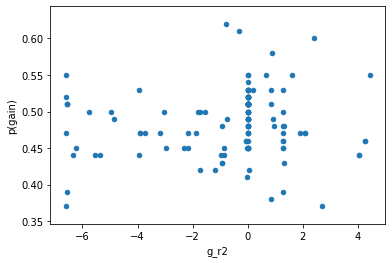

In [17]:
taxi_vehicle_collision_classes.plot.scatter(x='g_r2', y='p(gain)', )

## College Debt

In [18]:
college_debt_classes, college_debt_explanations = predict_class_for_features(
    rf_classifier,
    'college-debt-records-features',
    FEATURE_VECTOR
)

In [19]:
compute_precision_recall(college_debt_classes)

-- TP: 2
                                         name    g_r2  p(gain)      cf
0  Most- Recent- Cohorts- Scorecard- Elements 0.80812  0.66000 1.00000
1        College Scorecard Data - Most Recent 0.72774  0.66000 1.00000

-- TN: 0
Empty DataFrame
Columns: [name, g_r2, p(gain), cf]
Index: []

-- FP: 0
Empty DataFrame
Columns: [name, g_r2, p(gain), cf]
Index: []

-- FN: 0
Empty DataFrame
Columns: [name, g_r2, p(gain), cf]
Index: []

Precision: 1.0000
Recall: 1.0000


In [20]:
# Pearson between containment fraction and gain in R2
compute_pearson(college_debt_classes, 'cf', 'g_r2')

/opt/anaconda3/envs/python-3.6/lib/python3.6/site-packages/scipy/stats/stats.py:3399: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


nan

In [21]:
# Pearson between containment fraction and probability of being classified as gain
compute_pearson(college_debt_classes, 'cf', 'p(gain)')

nan

In [22]:
# Pearson between gain in R2 and probability of being classified as gain
compute_pearson(college_debt_classes, 'g_r2', 'p(gain)')

nan

## Poverty Estimation

In [23]:
poverty_estimation_classes, poverty_estimation_explanations = predict_class_for_features(
    rf_classifier,
    'poverty-estimation-records-features',
    FEATURE_VECTOR
)

In [24]:
compute_precision_recall(poverty_estimation_classes)

-- TP: 1
                     name    g_r2  p(gain)      cf
0  Unemployment in the US 0.02825  0.62000 1.00000

-- TN: 1
                              name     g_r2  p(gain)      cf
7  SF Development Pipeline 2016 Q3 -0.31018  0.49000 0.00128

-- FP: 7
                              name     g_r2  p(gain)      cf
1  SF Development Pipeline 2017 Q2 -0.29071  0.53000 0.00128
2  SF Development Pipeline 2016 Q4 -0.29903  0.52000 0.00159
3  SF Development Pipeline 2017 Q3 -0.29914  0.52000 0.00128
4  SF Development Pipeline 2014 Q4 -0.29982  0.53000 0.00032
5  SF Development Pipeline 2017 Q1 -0.30170  0.52000 0.00128
6  SF Development Pipeline 2016 Q2 -0.30469  0.50000 0.00064
8  SF Development Pipeline 2019 Q2 -0.31780  0.53000 0.00128

-- FN: 0
Empty DataFrame
Columns: [name, g_r2, p(gain), cf]
Index: []

Precision: 0.1250
Recall: 1.0000


In [25]:
# Pearson between containment fraction and gain in R2
compute_pearson(poverty_estimation_classes, 'cf', 'g_r2')

0.9976101832348241

In [26]:
# Pearson between containment fraction and probability of being classified as gain
compute_pearson(poverty_estimation_classes, 'cf', 'p(gain)')

0.9260949634227976

In [27]:
# Pearson between gain in R2 and probability of being classified as gain
compute_pearson(poverty_estimation_classes, 'g_r2', 'p(gain)')

0.9317987480777639